In [40]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
"""
not separated by year because author data is so oddly sparse
"""
def paper_count_plot_year(author_data, editor_no_dup, editor_rand_dup, journal):
    authors = pd.read_csv(author_data)
    authors = authors.dropna(subset=['PaperCount'])
    editors_no_dup = pd.read_csv(editor_no_dup)
    editors_rand_dup = pd.read_csv(editor_rand_dup)
    
    author_papers = authors['PaperCount']
    editor_papers_no_dup = editors_no_dup['PaperCount']
    editor_papers_rand_dup = editors_rand_dup['PaperCount']
    data = [author_papers, editor_papers_no_dup, editor_papers_rand_dup]
    
    fig = plt.figure(figsize =(6,4))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_xticklabels(['Authors', 'Editors (No Duplicates)','Editors (Random Duplicates)'])
    bp = ax.boxplot(data)
    plt.title(f'Paper Counts of Authors and Editors at {journal.upper()}')
    plt.show()

In [3]:
def call_paper_count_plot(journal):
    paper_count_plot_year(f"../author_data/cleaned/{journal}_authors_cleaned.csv", 
                          f"../mag_processed/no_duplicates/{journal}_no_duplicates.csv", 
                          f"../mag_processed/random_duplicates/{journal}_random_duplicates.csv", 
                          journal)

In [35]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [36]:
"""
for authors, all entries are counted
for editors, place them in the first year of their tenure (otherwise there is overcounting)
"""
def paper_count_buckets(author_data, editor_no_dup, editor_rand_dup, tenures, journal, bins, labels):
    authors = pd.read_csv(author_data)
    authors = authors.dropna(subset=['PaperCount'])
    editors_no_dup = pd.read_csv(editor_no_dup)
    editors_rand_dup = pd.read_csv(editor_rand_dup)
    tenures = pd.read_csv(tenures, usecols=['Name', 'Role', 'Start'])
    
    editors_no_dup = editors_no_dup.merge(tenures, on=['Name'], how='inner')
    editors_rand_dup = editors_rand_dup.merge(tenures, on=['Name'], how='inner')
    
    authors['Bucket'] = pd.cut(x = authors['Year'], bins = bins, labels = labels, include_lowest = True)
    editors_no_dup['Bucket'] = pd.cut(x = editors_no_dup['Start'], bins = bins, labels = labels, 
                                      include_lowest = True)
    editors_rand_dup['Bucket'] = pd.cut(x = editors_rand_dup['Start'], bins = bins, labels = labels, 
                                        include_lowest = True)
    
    author_papers = []
    editor_papers_no_dup = []
    editor_papers_rand_dup = []
    
    for label in labels:
        tmp_authors = authors[authors['Bucket'] == label]['PaperCount']
        tmp_no_dup = editors_no_dup[editors_no_dup['Bucket'] == label]['PaperCount']
        tmp_rand_dup = editors_rand_dup[editors_rand_dup['Bucket'] == label]['PaperCount']
        author_papers.append(tmp_authors)
        editor_papers_no_dup.append(tmp_no_dup)
        editor_papers_rand_dup.append(tmp_rand_dup)
    
    return author_papers, editor_papers_no_dup, editor_papers_rand_dup

In [54]:
def call_paper_count_buckets(journal):
    author_data = f"../author_data/cleaned/{journal}_authors_cleaned.csv"
    no_dups = f"../mag_processed/no_duplicates/{journal}_no_duplicates.csv"
    rand_dups = f"../mag_processed/random_duplicates/{journal}_random_duplicates.csv"
    tenures = f"../editor_data/analysis/tenures/{journal}.tenures.csv"
    
    std_bins = [1994, 1998, 2003, 2008, 2013, 2018, 2023]
    std_labels = ['1994-1998', '1999-2003', '2004-2008', '2009-2013', '2014-2018', '2018-2023']
    
    eco_bins = [2007, 2011, 2016, 2021, 2023]
    eco_labels = ['2007-2011', '2012-2016', '2017-2021', '2022-2023']

    jpe_bins = [2017, 2021, 2023]
    jpe_labels = ['2017-2021', '2022-2023']
    
    if journal == "eco":
        a, b, c = paper_count_buckets(author_data, no_dups, rand_dups, tenures, "eco", eco_bins, eco_labels)
        return a, b, c, eco_labels
    elif journal == "jpe":
        a, b, c = paper_count_buckets(author_data, no_dups, rand_dups, tenures, "jpe", jpe_bins, jpe_labels)
        return a, b, c, jpe_labels
    else:
        a, b, c = paper_count_buckets(author_data, no_dups, rand_dups, tenures, journal, std_bins, std_labels)
        return a, b, c, std_labels

In [70]:
def plot(journal, authors, no_dups, rand_dups, ticks):
    
    #duplicates removed
    bpl = plt.boxplot(authors, positions=np.array(range(len(authors)))*2.0-0.4, sym='', widths=0.6)
    bpr = plt.boxplot(no_dups, positions=np.array(range(len(no_dups)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#D7191C') 
    set_box_color(bpr, '#2C7BB6')

    plt.plot([], c='#D7191C', label='Authors')
    plt.plot([], c='#2C7BB6', label='Editors')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    plt.title(f'Paper Counts of Authors and Editors at {journal.upper()} (No Duplicates)')
    plt.show()
    
    #random duplicates
    bpl = plt.boxplot(authors, positions=np.array(range(len(authors)))*2.0-0.4, sym='', widths=0.6)
    bpr = plt.boxplot(no_dups, positions=np.array(range(len(no_dups)))*2.0+0.4, sym='', widths=0.6)
    set_box_color(bpl, '#097969') 
    set_box_color(bpr, '#FF5733')

    plt.plot([], c='#097969', label='Authors')
    plt.plot([], c='#FF5733', label='Editors')
    plt.legend()

    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    plt.title(f'Paper Counts of Authors and Editors at {journal.upper()} (Random Duplicates)')
    plt.show()

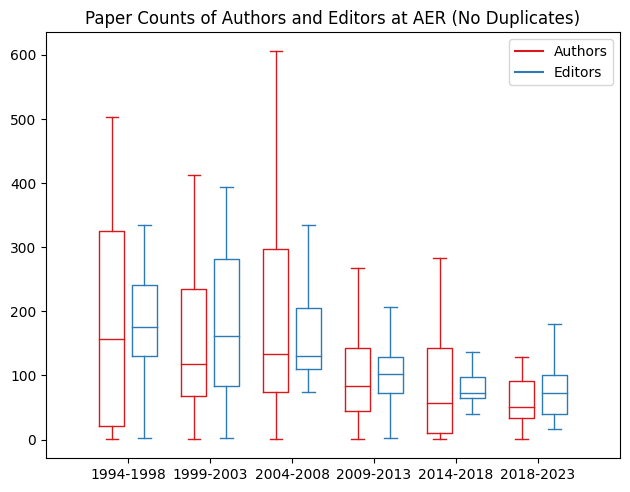

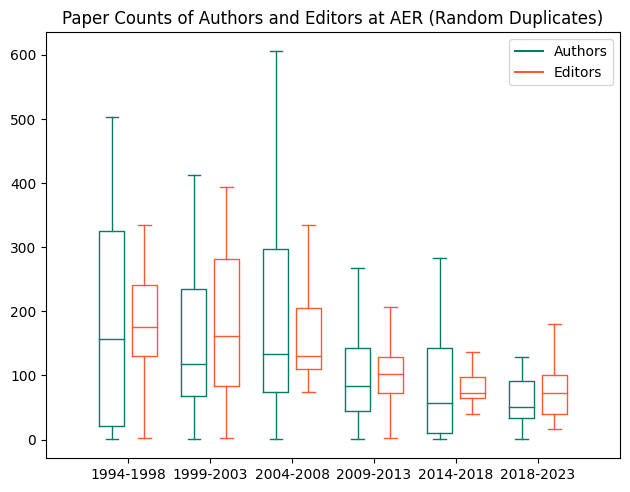

In [72]:
author, no_dups, rand_dups, labels = call_paper_count_buckets("aer")
plot("aer", author, no_dups, rand_dups, labels)

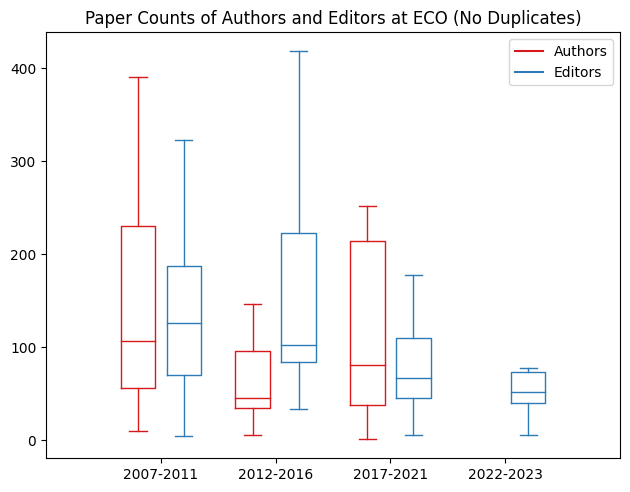

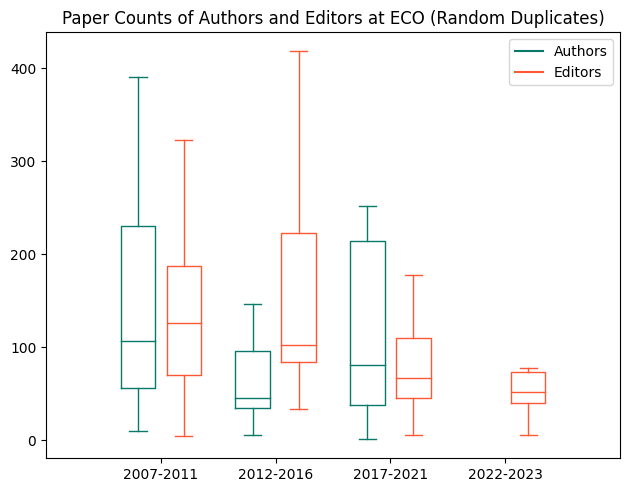

In [79]:
author, no_dups, rand_dups, labels = call_paper_count_buckets("eco")
plot("eco", author, no_dups, rand_dups, labels)

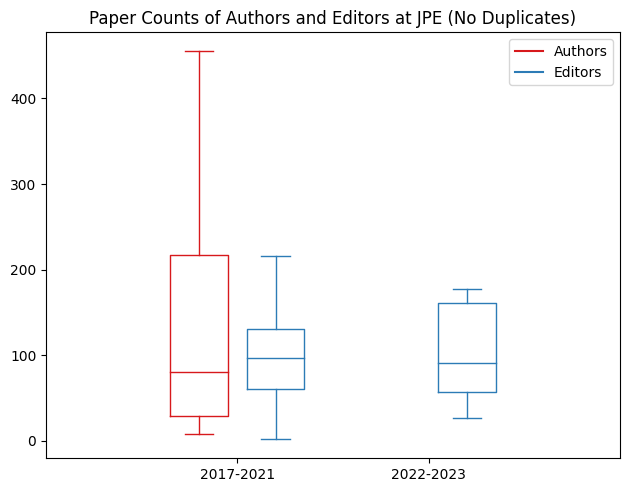

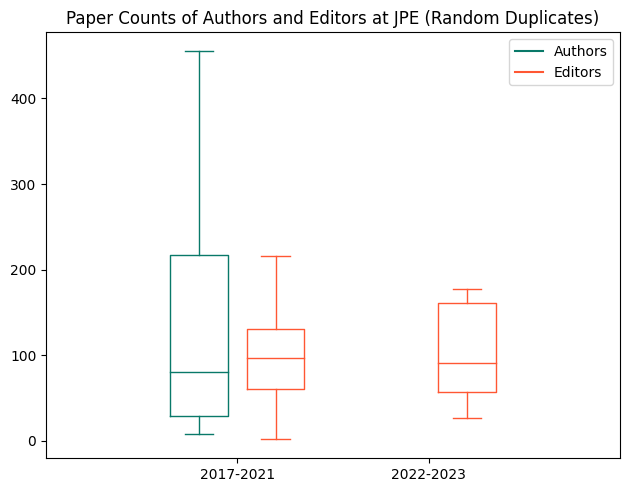

In [75]:
author, no_dups, rand_dups, labels = call_paper_count_buckets("jpe")
plot("jpe", author, no_dups, rand_dups, labels)

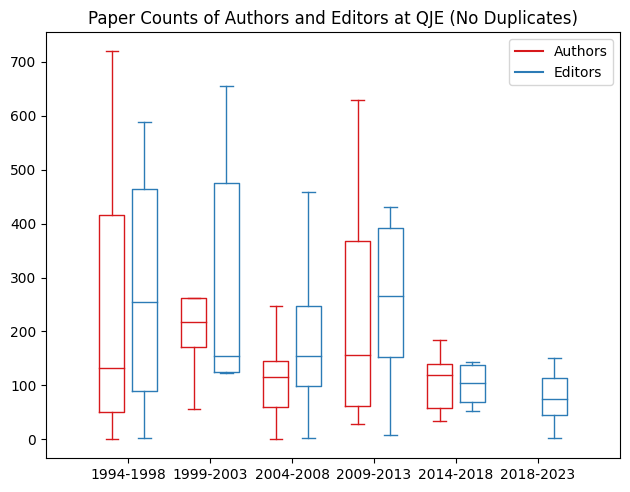

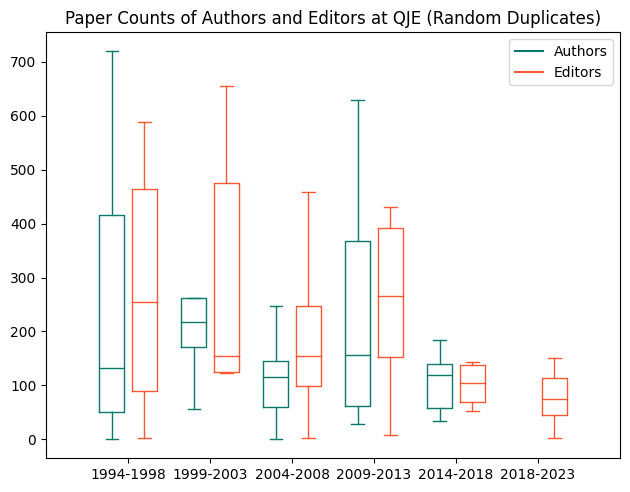

In [76]:
author, no_dups, rand_dups, labels = call_paper_count_buckets("qje")
plot("qje", author, no_dups, rand_dups, labels)

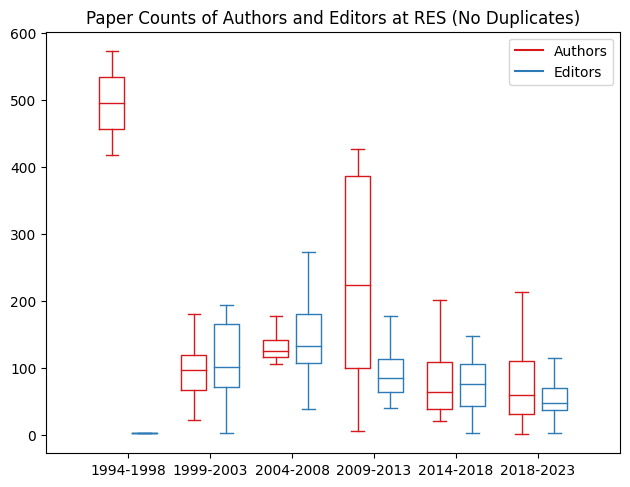

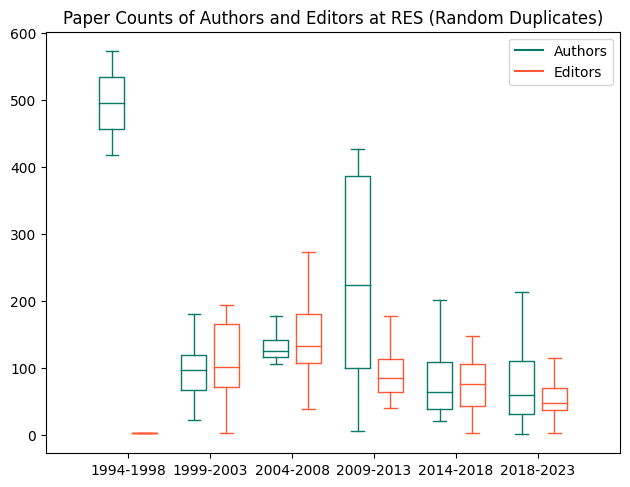

In [80]:
author, no_dups, rand_dups, labels = call_paper_count_buckets("res")
plot("res", author, no_dups, rand_dups, labels)